# Attractor stability visualization

## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import numpy as np
import matplotlib
import re
matplotlib.style.use('seaborn')

## Util

In [2]:
def read(path):
    df = pd.read_excel(path+"Final_states.xlsx", index_col=0)
    return df.transpose()

In [3]:
def calculate_final_states_and_attractors(df):
    states = df.index.to_numpy()
    initial_states = []
    attractors = []
    final_states = []
    for i in states:
        state = i.split('_')
        
        initial_states.append(state[0])
        attractors.append(state[-1])
        final_states.append('_'.join(re.findall("[A-Z]+", state[-1])))
        
    df.insert(0, 'initial_state', initial_states)
    df.insert(0, 'final_state', final_states)
    df.insert(0, 'attractors', attractors)
    return df

In [4]:
def plot_distribution(df, fname ,title, field_name='final_state', steps=500):
    df2 = pd.DataFrame(df.groupby(['initial_state', field_name])['count'].sum()).query(f'count > {steps*0.05}')
    df3 = df2.reset_index()

    init = df3['initial_state'].unique()
    final = df3[field_name].unique()

    matrix = [{fin: df2.loc[init_s, fin][0] if fin in df2.loc[init_s].index else 0 for fin in final} for init_s in init]
    df4 = pd.DataFrame(matrix, index=init)
    ax = df4.plot.bar(stacked=True)

    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))

    summ = [sum(a) for _, a in df4.iterrows()]
    for i, row in df4.reset_index().iloc[:, 1:].iterrows():
        current_sum = 0
        for j, val in enumerate(row):
            if val/summ[i] > 0.03:
                plt.text(i, current_sum + val / 2, f"{(val/summ[i]*100):.1f}%", ha='center', va='center', color='white', fontweight='bold')
            current_sum += val
    plt.title(title, fontsize=20)
    plt.tight_layout()
    plt.savefig(fname)

# Init

In [149]:
df = read(path="/")
df = calculate_final_states_and_attractors(df)

In [151]:
df.head()

,attractors,final_state,initial_state,AKT_1,AKT_2,AXIN1_1,AXIN1_2,AXIN2_1,AXIN2_2,BTrCP_1,...,max steps,average steps,node_diff_from_E_cell_1,dist_from_E_cell_1,node_diff_from_M_cell_1,dist_from_M_cell_1,node_diff_from_E_cell_2,dist_from_E_cell_2,node_diff_from_M_cell_2,dist_from_M_cell_2
EE_AKT_1_MM,MM,MM,EE,True,True,False,False,True,True,False,...,17867,11197.8,AKT\nAXIN1\nAXIN2\nBTrCP\nBcatenin_memb\nBcate...,99,NaN,0,AKT\nAXIN1\nAXIN2\nBTrCP\nBcatenin_memb\nBcate...,99,NaN,0
EE_AKT_1_EE,EE,EE,EE,False,False,True,True,False,False,True,...,8617,2443.57,NaN,0,AKT\nAXIN1\nAXIN2\nBTrCP\nBcatenin_memb\nBcate...,99,NaN,0,AKT\nAXIN1\nAXIN2\nBTrCP\nBcatenin_memb\nBcate...,99
EE_AKT_1_E1E,E1E,E_E,EE,False,False,True,True,False,False,False,...,11038,4888.06,BTrCP\nBcatenin_memb\nBcatenin_nuc\nCD44\nCsn\...,16,AKT\nAXIN1\nAXIN2\nCD44a\nCDC42\nCHD1L\nCsl\nD...,85,NaN,0,AKT\nAXIN1\nAXIN2\nBTrCP\nBcatenin_memb\nBcate...,99
EE_AKT_1_M1I0,M1I0,M_I,EE,False,False,False,False,True,False,False,...,14871,10236.2,AXIN1\nAXIN2\nBTrCP\nBcatenin_memb\nBcatenin_n...,64,AKT\nCD44a\nCDC42\nCHD1L\nCsl\nDest_compl\nESR...,37,AXIN1\nBTrCP\nBcatenin_memb\nBcatenin_nuc\nCD4...,44,AKT\nAXIN2\nCD44a\nCDC42\nCHD1L\nDELTA_jux\nDN...,57
EE_AKT_1_M2I1,M2I1,M_I,EE,False,False,False,False,True,False,False,...,12446,12446,AXIN1\nAXIN2\nBTrCP\nBcatenin_memb\nBcatenin_n...,48,AKT\nCD44a\nCDC42\nCHD1L\nCsl\nDNMT1\nDNMT3\nD...,53,AXIN1\nBTrCP\nBcatenin_memb\nBcatenin_nuc\nCD4...,35,AKT\nAXIN2\nCD44a\nCDC42\nCHD1L\nDELTA_jux\nDN...,66


## Plot 

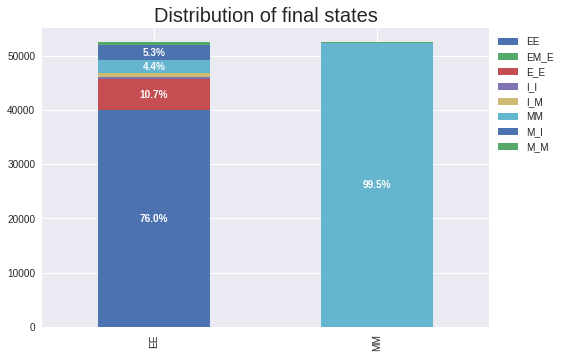

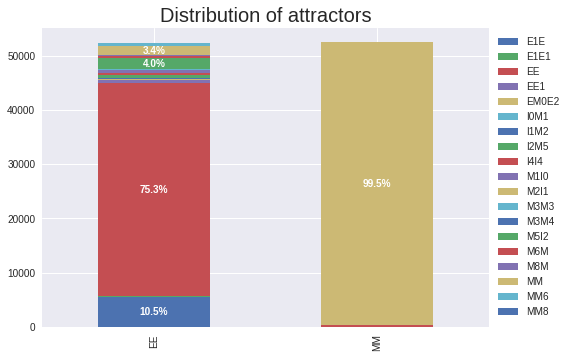

In [150]:
plot_distribution(df, 'Distribution of final states')
plot_distribution(df, 'Distribution of attractors', 'attractors')

## Kiértékelés

In [9]:
paths_and_names = [("/Users/ftedo/Desktop/Szakdolgozat/simulations/intercellular/no-perturbation/asynchronous/original/", "inter_nopert_wasync_origin"),
                  ("/Users/ftedo/Desktop/Szakdolgozat/simulations/intercellular/no-perturbation/asynchronous/with-pathways/", "inter_nopert_wasync_pathw"),
                    ("/Users/ftedo/Desktop/Szakdolgozat/simulations/intercellular/perturbation/asynchronous/original/", "inter_pert_wasync_origin"),
                   ("/Users/ftedo/Desktop/Szakdolgozat/simulations/intercellular/perturbation/asynchronous/with-pathways/", "inter_pert_wasync_pathw"),
                   ("/Users/ftedo/Desktop/Szakdolgozat/simulations/single-cell/no-perturbation/asynchronous/original/", "single_nopert_wasync_origin"),
                   ("/Users/ftedo/Desktop/Szakdolgozat/simulations/single-cell/no-perturbation/asynchronous/with-connections/", "single_nopert_wasync_pathw"),
                   ("/Users/ftedo/Desktop/Szakdolgozat/simulations/single-cell/perturbation/asynchronous/with-pathways/", "single_pert_wasync_pathw"),
                   ("/Users/ftedo/Desktop/Szakdolgozat/simulations/single-cell/perturbation/asynchronous/original/", "single_pert_wasync_origin")
                  ]

inter_nopert_wasync_origin
inter_nopert_wasync_pathw
inter_pert_wasync_origin
inter_pert_wasync_pathw
single_nopert_wasync_origin
single_nopert_wasync_pathw
single_pert_wasync_pathw
single_pert_wasync_origin


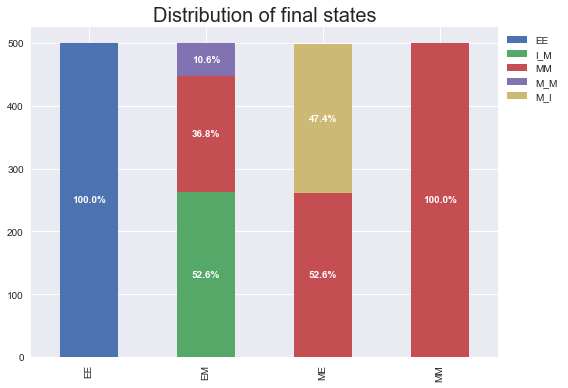

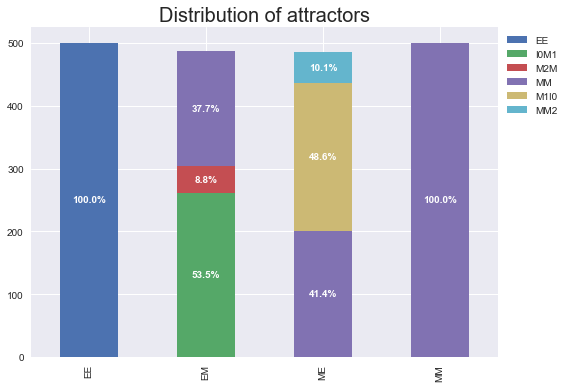

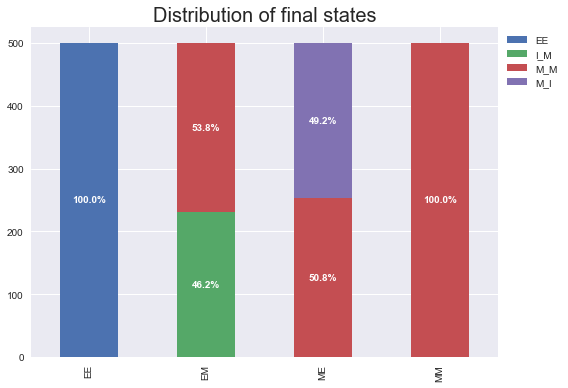

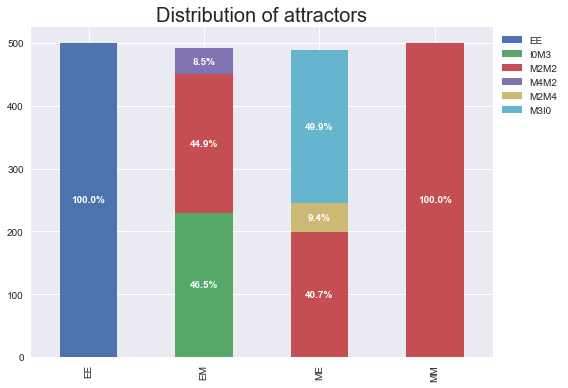

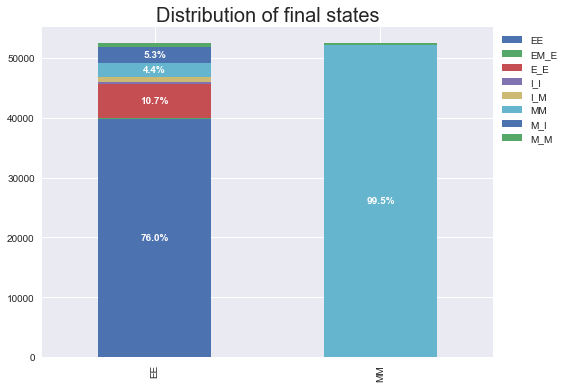

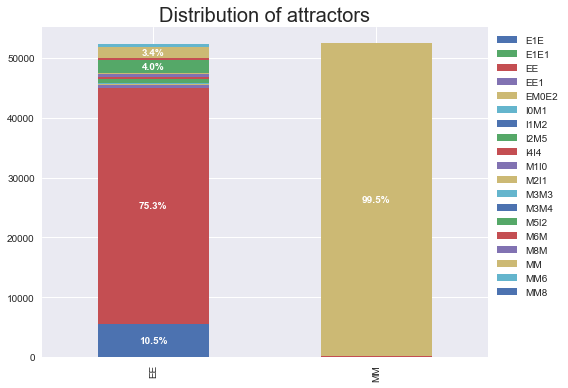

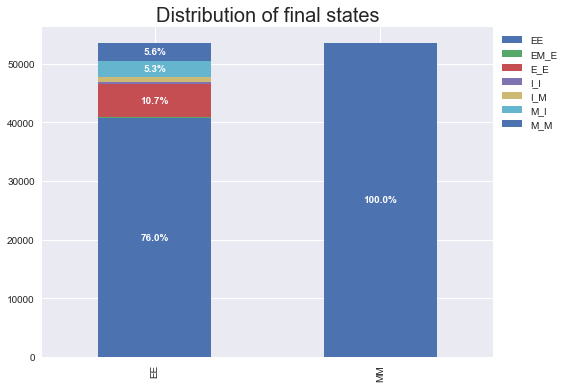

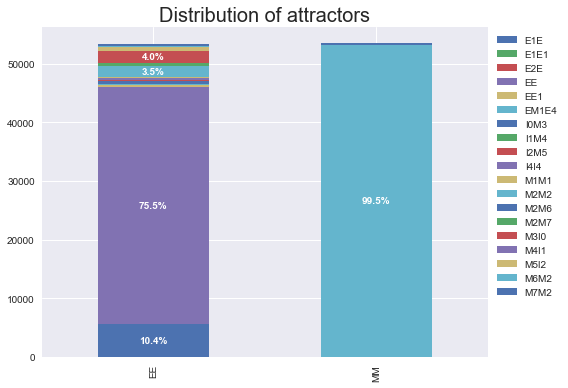

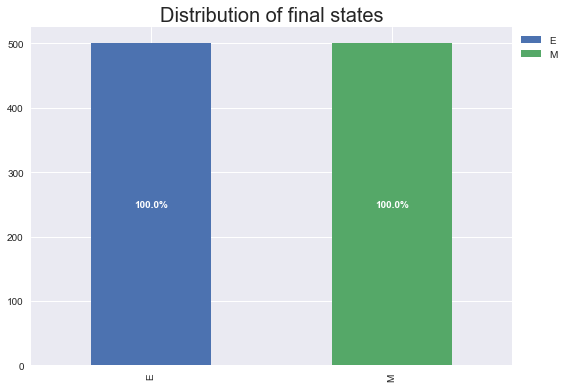

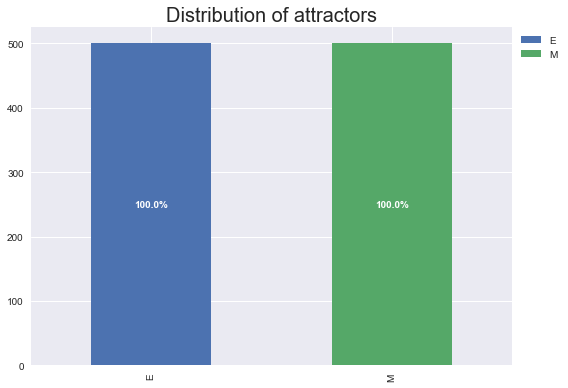

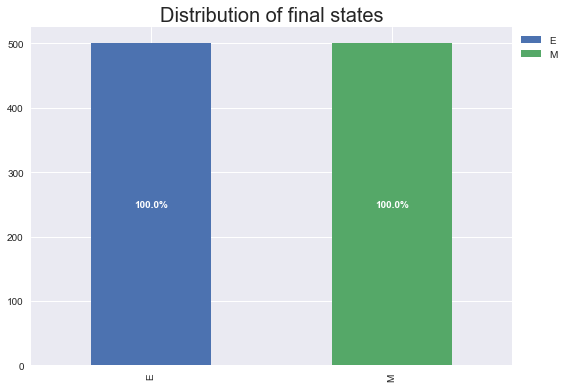

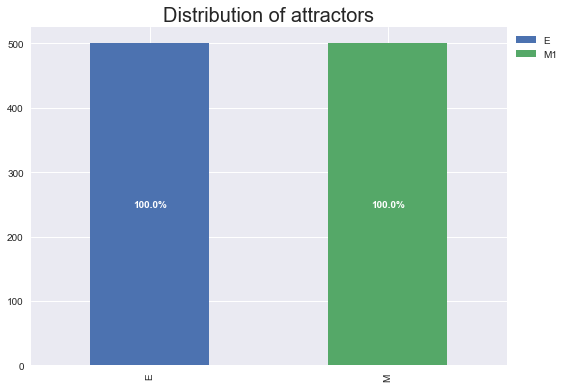

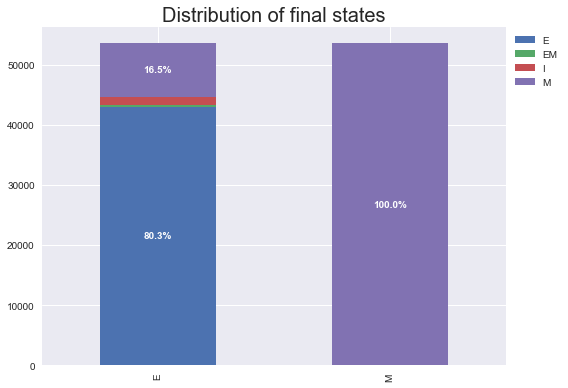

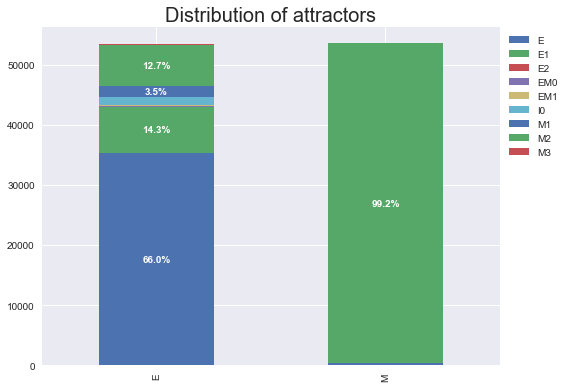

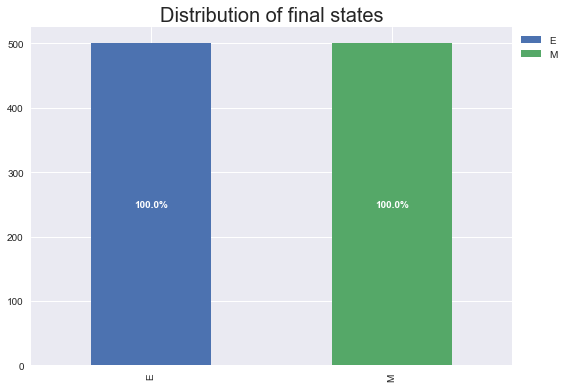

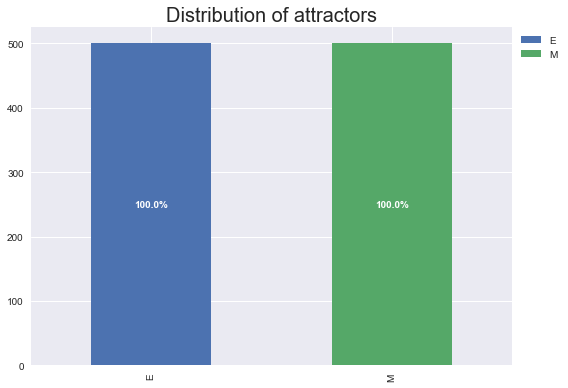

In [10]:
for path, name in paths_and_names:
    df = read(path=path)
    df = calculate_final_states_and_attractors(df)
    plot_distribution(df, fname = path+name+'final', title = 'Distribution of final states')
    plot_distribution(df, fname = path+name+'attractors', title = 'Distribution of attractors', field_name = 'attractors')
    print(name)